In [ ]:
%load_ext autoreload
%autoreload 2


In [ ]:
from comet_ml import Experiment
from comet_ml.integration.pytorch import log_model

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm import tqdm
from datetime import datetime
import pandas as pd
import pytz
import numpy as np
from capi import api_key

from models.gan_models import *
import yfinance as yf
import MetaTrader5 as mt5
import random
import os

In [ ]:
#api_key = os.environ['COMET_API_KEY']
#api_key = ''

In [ ]:
experiment = Experiment(
  api_key=api_key,
  project_name="tail-price",
  workspace="artaasd95"
)

In [ ]:
mt5.initialize()

print('loading current tf data')
utc_from = datetime(2021, 1, 1, tzinfo=pytz.timezone("Asia/Nicosia"))
utc_to = datetime.now(pytz.timezone("Asia/Nicosia"))

data = mt5.copy_rates_range('XAUUSD', mt5.TIMEFRAME_H4, utc_from, utc_to)
data = pd.DataFrame(data)
time_data = data.time
data.drop(columns=['tick_volume', 'spread', 'real_volume'], inplace=True)

In [ ]:
data.to_csv('xau_2021_H4.csv')

In [ ]:
data = pd.read_csv('xau_2021_H4.csv')

In [ ]:
data

In [ ]:
input_size = 1
hidden_size = 512
seq_length = 50
num_layers = 8
batch_size = 64
num_epochs = 100
learning_rate = 0.0005
lambda_gp = 10
n_critic = 5
# Initialize models
main_gen = MainGenerator(input_size, hidden_size, num_layers, 0.5, 1)
discriminator = Discriminator(input_size, int(hidden_size/2), num_layers-3, 0.5)

noise_gen = NoiseGenerator(input_size, 512, 1, 0.5)
noise_disc = NoiseDiscriminator(input_size, 512, 1, 0.5)

In [ ]:
enable_cuda = False
device = torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')

In [38]:
def compute_gradient_penalty(D, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.tensor(np.random.random((real_samples.size(0), 1)), dtype=torch.float).to(device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    d_interpolates = D(interpolates)
    #fake = torch.ones(batch_size, 1).to(device)
    fake = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
    # Get gradient w.r.t. interpolates
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

In [39]:
main_gen.to(device)
noise_gen.to(device)
discriminator.to(device)

Discriminator(
  (lstm): LSTM(1, 256, num_layers=5, batch_first=True, dropout=0.5)
  (fc1): Linear(in_features=256, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=1, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.2)
)

In [40]:
optimizer_G = torch.optim.AdamW(main_gen.parameters(), lr=learning_rate)
optimizer_D = torch.optim.AdamW(discriminator.parameters(), lr=learning_rate)

optimizer_NG = torch.optim.AdamW(noise_gen.parameters(), lr=learning_rate)
optimizer_ND = torch.optim.AdamW(noise_disc.parameters(), lr=learning_rate)

optim_g_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer_G, 0.1)
optim_d_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer_D, 0.1)

optim_ng_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer_NG, 0.1)
optim_nd_sched = torch.optim.lr_scheduler.ExponentialLR(optimizer_ND, 0.1)

In [41]:
cauchy_dist = torch.distributions.cauchy.Cauchy(loc=0, scale=0.5)

In [42]:
# Training loop
adversarial_loss = F.mse_loss
adversarial_loss = nn.BCELoss()
batch_size_noise = 256
for epoch in tqdm(range(200)):
    z1 = cauchy_dist.sample([batch_size_noise, 1])
    z1 = z1.to(device)
    #z2 = cauchy_dist.sample([1])
    # valid = torch.ones(batch_size_noise, 1, device=device)
    # fake = torch.zeros(batch_size_noise, 1, device=device)

    valid = Variable(torch.FloatTensor(batch_size_noise, 1).fill_(1.0), requires_grad=False)
    fake = Variable(torch.FloatTensor(batch_size_noise, 1).fill_(0.0), requires_grad=False)

    # Generate fake data
    #fake_main = main_gen(price)
    fake_noise = noise_gen(torch.rand([batch_size_noise, 1]))
    
    optimizer_NG.zero_grad()
    g_loss = adversarial_loss(noise_disc(fake_noise), valid)
    g_loss.backward()
    optimizer_NG.step()
    
    # Train generator
    optimizer_ND.zero_grad()
    
    valid_d_loss = adversarial_loss(noise_disc(z1), valid)
    fake_d_loss = adversarial_loss(noise_disc(fake_noise.detach()), fake)
    
    d_loss = (fake_d_loss + valid_d_loss) / 2
    d_loss.backward()
    optimizer_ND.step()


    optim_ng_sched.step()
    optim_nd_sched.step()

    print(f"Epoch [{epoch+1}/{num_epochs}]  Discriminator Loss: {d_loss.item()}  Generator Loss: {g_loss.item()}")
    experiment.log_metric('Noise Generator\Whole Train', g_loss.item(), step=epoch)
    experiment.log_metric('Noise Discriminator\Whole Train', d_loss.item(), step=epoch)


  2%|▏         | 3/200 [00:00<00:24,  7.99it/s]

Epoch [1/100]  Discriminator Loss: 0.7321289777755737  Generator Loss: 0.7167172431945801
Epoch [2/100]  Discriminator Loss: 0.6711727976799011  Generator Loss: 0.6638600826263428
Epoch [3/100]  Discriminator Loss: 0.6738688945770264  Generator Loss: 0.6555294990539551


  2%|▎         | 5/200 [00:00<00:19, 10.04it/s]

Epoch [4/100]  Discriminator Loss: 0.6785016059875488  Generator Loss: 0.6567602157592773
Epoch [5/100]  Discriminator Loss: 0.6763778924942017  Generator Loss: 0.6576271057128906
Epoch [6/100]  Discriminator Loss: 0.6729595065116882  Generator Loss: 0.657569944858551


  4%|▍         | 9/200 [00:00<00:16, 11.70it/s]

Epoch [7/100]  Discriminator Loss: 0.6743687391281128  Generator Loss: 0.6556312441825867
Epoch [8/100]  Discriminator Loss: 0.6699609160423279  Generator Loss: 0.6533228754997253
Epoch [9/100]  Discriminator Loss: 0.6780487298965454  Generator Loss: 0.6511847972869873


  6%|▌         | 11/200 [00:01<00:15, 12.29it/s]

Epoch [10/100]  Discriminator Loss: 0.6658498048782349  Generator Loss: 0.6561504006385803
Epoch [11/100]  Discriminator Loss: 0.675247848033905  Generator Loss: 0.6530535221099854
Epoch [12/100]  Discriminator Loss: 0.6682347059249878  Generator Loss: 0.6596575379371643


  8%|▊         | 15/200 [00:01<00:15, 12.30it/s]

Epoch [13/100]  Discriminator Loss: 0.6740747690200806  Generator Loss: 0.657694399356842
Epoch [14/100]  Discriminator Loss: 0.6715173721313477  Generator Loss: 0.6574991941452026
Epoch [15/100]  Discriminator Loss: 0.6757882833480835  Generator Loss: 0.6604217290878296


  8%|▊         | 17/200 [00:01<00:14, 12.84it/s]

Epoch [16/100]  Discriminator Loss: 0.6761256456375122  Generator Loss: 0.6544456481933594
Epoch [17/100]  Discriminator Loss: 0.6732297539710999  Generator Loss: 0.6603171825408936
Epoch [18/100]  Discriminator Loss: 0.6722882390022278  Generator Loss: 0.6573776602745056


 10%|█         | 21/200 [00:01<00:13, 12.80it/s]

Epoch [19/100]  Discriminator Loss: 0.6723684072494507  Generator Loss: 0.6601493954658508
Epoch [20/100]  Discriminator Loss: 0.6749253273010254  Generator Loss: 0.6583746075630188
Epoch [21/100]  Discriminator Loss: 0.674945592880249  Generator Loss: 0.6594683527946472


 12%|█▏        | 23/200 [00:01<00:13, 12.83it/s]

Epoch [22/100]  Discriminator Loss: 0.6728671789169312  Generator Loss: 0.6528833508491516
Epoch [23/100]  Discriminator Loss: 0.6761128902435303  Generator Loss: 0.6568882465362549
Epoch [24/100]  Discriminator Loss: 0.6679099798202515  Generator Loss: 0.6568989753723145


 14%|█▎        | 27/200 [00:02<00:13, 13.14it/s]

Epoch [25/100]  Discriminator Loss: 0.672113299369812  Generator Loss: 0.6599352359771729
Epoch [26/100]  Discriminator Loss: 0.6710923910140991  Generator Loss: 0.6598474383354187
Epoch [27/100]  Discriminator Loss: 0.6685242652893066  Generator Loss: 0.6577602028846741


 14%|█▍        | 29/200 [00:02<00:13, 12.54it/s]

Epoch [28/100]  Discriminator Loss: 0.6716752052307129  Generator Loss: 0.6549863815307617
Epoch [29/100]  Discriminator Loss: 0.6686414480209351  Generator Loss: 0.6601085662841797
Epoch [30/100]  Discriminator Loss: 0.6748565435409546  Generator Loss: 0.6572213172912598


 16%|█▌        | 31/200 [00:02<00:13, 12.43it/s]

Epoch [31/100]  Discriminator Loss: 0.6687502861022949  Generator Loss: 0.6594341397285461
Epoch [32/100]  Discriminator Loss: 0.6723178625106812  Generator Loss: 0.6569088101387024
Epoch [33/100]  Discriminator Loss: 0.6717404127120972  Generator Loss: 0.6584216952323914


 18%|█▊        | 35/200 [00:02<00:14, 11.06it/s]

Epoch [34/100]  Discriminator Loss: 0.6845183968544006  Generator Loss: 0.655526876449585
Epoch [35/100]  Discriminator Loss: 0.6724706888198853  Generator Loss: 0.6583835482597351
Epoch [36/100]  Discriminator Loss: 0.6798465251922607  Generator Loss: 0.6560112237930298


 20%|█▉        | 39/200 [00:03<00:14, 11.10it/s]

Epoch [37/100]  Discriminator Loss: 0.6746347546577454  Generator Loss: 0.655279278755188
Epoch [38/100]  Discriminator Loss: 0.6744682788848877  Generator Loss: 0.6562791466712952
Epoch [39/100]  Discriminator Loss: 0.6711405515670776  Generator Loss: 0.6555812358856201


 20%|██        | 41/200 [00:03<00:14, 10.80it/s]

Epoch [40/100]  Discriminator Loss: 0.6715794801712036  Generator Loss: 0.6556445360183716
Epoch [41/100]  Discriminator Loss: 0.6734486818313599  Generator Loss: 0.6574373841285706
Epoch [42/100]  Discriminator Loss: 0.6681691408157349  Generator Loss: 0.6565442085266113


 22%|██▎       | 45/200 [00:03<00:13, 11.87it/s]

Epoch [43/100]  Discriminator Loss: 0.6725962162017822  Generator Loss: 0.6560948491096497
Epoch [44/100]  Discriminator Loss: 0.675514280796051  Generator Loss: 0.6543031334877014
Epoch [45/100]  Discriminator Loss: 0.6707512140274048  Generator Loss: 0.6542221903800964


 24%|██▎       | 47/200 [00:04<00:12, 12.23it/s]

Epoch [46/100]  Discriminator Loss: 0.6733559370040894  Generator Loss: 0.6566320061683655
Epoch [47/100]  Discriminator Loss: 0.6759675741195679  Generator Loss: 0.6581273674964905
Epoch [48/100]  Discriminator Loss: 0.6680107116699219  Generator Loss: 0.6560797095298767


 26%|██▌       | 51/200 [00:04<00:11, 12.71it/s]

Epoch [49/100]  Discriminator Loss: 0.6738573908805847  Generator Loss: 0.6583305597305298
Epoch [50/100]  Discriminator Loss: 0.6659449338912964  Generator Loss: 0.6552936434745789
Epoch [51/100]  Discriminator Loss: 0.6766265034675598  Generator Loss: 0.6567453145980835


 26%|██▋       | 53/200 [00:04<00:11, 12.86it/s]

Epoch [52/100]  Discriminator Loss: 0.6824303269386292  Generator Loss: 0.6538836359977722
Epoch [53/100]  Discriminator Loss: 0.6681782007217407  Generator Loss: 0.659012496471405
Epoch [54/100]  Discriminator Loss: 0.6714963912963867  Generator Loss: 0.655067503452301


 28%|██▊       | 57/200 [00:04<00:10, 13.26it/s]

Epoch [55/100]  Discriminator Loss: 0.6678986549377441  Generator Loss: 0.6568470001220703
Epoch [56/100]  Discriminator Loss: 0.6707209348678589  Generator Loss: 0.6585326194763184
Epoch [57/100]  Discriminator Loss: 0.6730749011039734  Generator Loss: 0.6575442552566528


 30%|██▉       | 59/200 [00:04<00:10, 13.25it/s]

Epoch [58/100]  Discriminator Loss: 0.6760588884353638  Generator Loss: 0.6594815850257874
Epoch [59/100]  Discriminator Loss: 0.6725232005119324  Generator Loss: 0.652961254119873
Epoch [60/100]  Discriminator Loss: 0.6688035726547241  Generator Loss: 0.6571773290634155


 32%|███▏      | 63/200 [00:05<00:09, 13.77it/s]

Epoch [61/100]  Discriminator Loss: 0.6744883060455322  Generator Loss: 0.6566011905670166
Epoch [62/100]  Discriminator Loss: 0.6759864091873169  Generator Loss: 0.6601585149765015
Epoch [63/100]  Discriminator Loss: 0.6692639589309692  Generator Loss: 0.65885990858078
Epoch [64/100]  Discriminator Loss: 0.6739615201950073  Generator Loss: 0.6578430533409119


 34%|███▎      | 67/200 [00:05<00:10, 13.19it/s]

Epoch [65/100]  Discriminator Loss: 0.6766167879104614  Generator Loss: 0.6557919979095459
Epoch [66/100]  Discriminator Loss: 0.6775991916656494  Generator Loss: 0.6562234163284302
Epoch [67/100]  Discriminator Loss: 0.6687427759170532  Generator Loss: 0.6569811701774597


 34%|███▍      | 69/200 [00:05<00:09, 13.20it/s]

Epoch [68/100]  Discriminator Loss: 0.6716487407684326  Generator Loss: 0.6556211113929749
Epoch [69/100]  Discriminator Loss: 0.6768629550933838  Generator Loss: 0.6594432592391968
Epoch [70/100]  Discriminator Loss: 0.6735829710960388  Generator Loss: 0.6533051133155823


 36%|███▋      | 73/200 [00:05<00:09, 13.02it/s]

Epoch [71/100]  Discriminator Loss: 0.7319368124008179  Generator Loss: 0.6573737859725952
Epoch [72/100]  Discriminator Loss: 0.667771577835083  Generator Loss: 0.6598931550979614
Epoch [73/100]  Discriminator Loss: 0.6696381568908691  Generator Loss: 0.659515917301178


 38%|███▊      | 75/200 [00:06<00:09, 13.16it/s]

Epoch [74/100]  Discriminator Loss: 0.6763019561767578  Generator Loss: 0.6565026044845581
Epoch [75/100]  Discriminator Loss: 0.6758725643157959  Generator Loss: 0.6574181318283081
Epoch [76/100]  Discriminator Loss: 0.672273576259613  Generator Loss: 0.6568236947059631


 40%|███▉      | 79/200 [00:06<00:08, 13.56it/s]

Epoch [77/100]  Discriminator Loss: 0.6772656440734863  Generator Loss: 0.6582925915718079
Epoch [78/100]  Discriminator Loss: 0.6671090126037598  Generator Loss: 0.6543011665344238
Epoch [79/100]  Discriminator Loss: 0.6744828224182129  Generator Loss: 0.6558214426040649
Epoch [80/100]  Discriminator Loss: 0.6794703006744385  Generator Loss: 0.6558604836463928


 42%|████▏     | 83/200 [00:06<00:08, 14.00it/s]

Epoch [81/100]  Discriminator Loss: 0.6822835206985474  Generator Loss: 0.6552705764770508
Epoch [82/100]  Discriminator Loss: 0.6744680404663086  Generator Loss: 0.6547224521636963
Epoch [83/100]  Discriminator Loss: 0.6721189022064209  Generator Loss: 0.6584519147872925
Epoch [84/100]  Discriminator Loss: 0.6745598316192627  Generator Loss: 0.6583213210105896


 44%|████▎     | 87/200 [00:06<00:08, 13.32it/s]

Epoch [85/100]  Discriminator Loss: 0.6754661798477173  Generator Loss: 0.6587684750556946
Epoch [86/100]  Discriminator Loss: 0.6789015531539917  Generator Loss: 0.6581525802612305
Epoch [87/100]  Discriminator Loss: 0.6683861017227173  Generator Loss: 0.6562936305999756


 44%|████▍     | 89/200 [00:07<00:08, 13.33it/s]

Epoch [88/100]  Discriminator Loss: 0.6741271018981934  Generator Loss: 0.6552295684814453
Epoch [89/100]  Discriminator Loss: 0.6769778728485107  Generator Loss: 0.6550023555755615
Epoch [90/100]  Discriminator Loss: 0.6701066493988037  Generator Loss: 0.6566346287727356


 46%|████▋     | 93/200 [00:07<00:08, 13.24it/s]

Epoch [91/100]  Discriminator Loss: 0.6754724979400635  Generator Loss: 0.6546974182128906
Epoch [92/100]  Discriminator Loss: 0.6741604208946228  Generator Loss: 0.6541067361831665
Epoch [93/100]  Discriminator Loss: 0.6716094017028809  Generator Loss: 0.6564744114875793


 48%|████▊     | 95/200 [00:07<00:07, 13.23it/s]

Epoch [94/100]  Discriminator Loss: 0.6691118478775024  Generator Loss: 0.6599384546279907
Epoch [95/100]  Discriminator Loss: 0.6702507734298706  Generator Loss: 0.6570469737052917
Epoch [96/100]  Discriminator Loss: 0.6727256774902344  Generator Loss: 0.6585808992385864


 50%|████▉     | 99/200 [00:07<00:08, 12.42it/s]

Epoch [97/100]  Discriminator Loss: 0.6757375001907349  Generator Loss: 0.6528564095497131
Epoch [98/100]  Discriminator Loss: 0.6731367707252502  Generator Loss: 0.6589200496673584
Epoch [99/100]  Discriminator Loss: 0.6721850633621216  Generator Loss: 0.6570332050323486


 50%|█████     | 101/200 [00:08<00:07, 12.50it/s]

Epoch [100/100]  Discriminator Loss: 0.6756004095077515  Generator Loss: 0.6560980677604675
Epoch [101/100]  Discriminator Loss: 0.6810595989227295  Generator Loss: 0.6568270921707153
Epoch [102/100]  Discriminator Loss: 0.6740086078643799  Generator Loss: 0.6595509052276611


 52%|█████▎    | 105/200 [00:08<00:07, 12.97it/s]

Epoch [103/100]  Discriminator Loss: 0.6734663844108582  Generator Loss: 0.6552230715751648
Epoch [104/100]  Discriminator Loss: 0.6758326292037964  Generator Loss: 0.6587973833084106
Epoch [105/100]  Discriminator Loss: 0.6720638275146484  Generator Loss: 0.6556677222251892


 54%|█████▎    | 107/200 [00:08<00:07, 13.24it/s]

Epoch [106/100]  Discriminator Loss: 0.6770964860916138  Generator Loss: 0.6539633870124817
Epoch [107/100]  Discriminator Loss: 0.6714558601379395  Generator Loss: 0.6594372391700745
Epoch [108/100]  Discriminator Loss: 0.6738393306732178  Generator Loss: 0.6564784646034241


 56%|█████▌    | 111/200 [00:08<00:06, 13.25it/s]

Epoch [109/100]  Discriminator Loss: 0.6796597242355347  Generator Loss: 0.6554265022277832
Epoch [110/100]  Discriminator Loss: 0.6757157444953918  Generator Loss: 0.6581960320472717
Epoch [111/100]  Discriminator Loss: 0.6738409399986267  Generator Loss: 0.6606451869010925


 56%|█████▋    | 113/200 [00:08<00:06, 13.19it/s]

Epoch [112/100]  Discriminator Loss: 0.6755201816558838  Generator Loss: 0.6549407243728638
Epoch [113/100]  Discriminator Loss: 0.6749523878097534  Generator Loss: 0.6587933897972107
Epoch [114/100]  Discriminator Loss: 0.6745783090591431  Generator Loss: 0.656987190246582


 58%|█████▊    | 117/200 [00:09<00:06, 13.16it/s]

Epoch [115/100]  Discriminator Loss: 0.6819429397583008  Generator Loss: 0.6576169729232788
Epoch [116/100]  Discriminator Loss: 0.6785188317298889  Generator Loss: 0.6572177410125732
Epoch [117/100]  Discriminator Loss: 0.673277735710144  Generator Loss: 0.6573667526245117


 60%|█████▉    | 119/200 [00:09<00:06, 13.32it/s]

Epoch [118/100]  Discriminator Loss: 0.6773547530174255  Generator Loss: 0.6588049530982971
Epoch [119/100]  Discriminator Loss: 0.6751121282577515  Generator Loss: 0.655370831489563
Epoch [120/100]  Discriminator Loss: 0.6752287149429321  Generator Loss: 0.6575201153755188


 62%|██████▏   | 123/200 [00:09<00:05, 12.95it/s]

Epoch [121/100]  Discriminator Loss: 0.6706373691558838  Generator Loss: 0.6551544666290283
Epoch [122/100]  Discriminator Loss: 0.6701726913452148  Generator Loss: 0.6584265232086182
Epoch [123/100]  Discriminator Loss: 0.6699032783508301  Generator Loss: 0.657492458820343


 62%|██████▎   | 125/200 [00:09<00:05, 13.05it/s]

Epoch [124/100]  Discriminator Loss: 0.6715762615203857  Generator Loss: 0.6576783657073975
Epoch [125/100]  Discriminator Loss: 0.6796499490737915  Generator Loss: 0.6572245359420776
Epoch [126/100]  Discriminator Loss: 0.6738431453704834  Generator Loss: 0.6551255583763123


 64%|██████▍   | 129/200 [00:10<00:05, 12.71it/s]

Epoch [127/100]  Discriminator Loss: 0.6803445816040039  Generator Loss: 0.6580864191055298
Epoch [128/100]  Discriminator Loss: 0.6714516878128052  Generator Loss: 0.6547545790672302
Epoch [129/100]  Discriminator Loss: 0.6696627736091614  Generator Loss: 0.6564702987670898


 66%|██████▌   | 131/200 [00:10<00:05, 12.76it/s]

Epoch [130/100]  Discriminator Loss: 0.6735076308250427  Generator Loss: 0.6574985384941101
Epoch [131/100]  Discriminator Loss: 0.6760761141777039  Generator Loss: 0.6606100797653198
Epoch [132/100]  Discriminator Loss: 0.6697206497192383  Generator Loss: 0.6577945947647095


 68%|██████▊   | 135/200 [00:10<00:04, 13.18it/s]

Epoch [133/100]  Discriminator Loss: 0.6708865761756897  Generator Loss: 0.6547327041625977
Epoch [134/100]  Discriminator Loss: 0.6738277673721313  Generator Loss: 0.6561760902404785
Epoch [135/100]  Discriminator Loss: 0.6805282831192017  Generator Loss: 0.6537676453590393


 68%|██████▊   | 137/200 [00:10<00:04, 13.38it/s]

Epoch [136/100]  Discriminator Loss: 0.6768721342086792  Generator Loss: 0.655860424041748
Epoch [137/100]  Discriminator Loss: 0.6710314750671387  Generator Loss: 0.6549786925315857
Epoch [138/100]  Discriminator Loss: 0.6739249229431152  Generator Loss: 0.6538403034210205


 70%|███████   | 141/200 [00:11<00:04, 13.13it/s]

Epoch [139/100]  Discriminator Loss: 0.6684383749961853  Generator Loss: 0.6560270190238953
Epoch [140/100]  Discriminator Loss: 0.6735361814498901  Generator Loss: 0.6546529531478882
Epoch [141/100]  Discriminator Loss: 0.6762292385101318  Generator Loss: 0.6577214002609253


 72%|███████▏  | 143/200 [00:11<00:04, 12.94it/s]

Epoch [142/100]  Discriminator Loss: 0.6730711460113525  Generator Loss: 0.6566190123558044
Epoch [143/100]  Discriminator Loss: 0.6738573908805847  Generator Loss: 0.657480001449585
Epoch [144/100]  Discriminator Loss: 0.6777072548866272  Generator Loss: 0.6580222845077515


 74%|███████▎  | 147/200 [00:11<00:04, 13.05it/s]

Epoch [145/100]  Discriminator Loss: 0.6731413006782532  Generator Loss: 0.655311644077301
Epoch [146/100]  Discriminator Loss: 0.6742980480194092  Generator Loss: 0.655962347984314
Epoch [147/100]  Discriminator Loss: 0.6708853244781494  Generator Loss: 0.6584499478340149


 74%|███████▍  | 149/200 [00:11<00:04, 12.72it/s]

Epoch [148/100]  Discriminator Loss: 0.6698464155197144  Generator Loss: 0.6529422998428345
Epoch [149/100]  Discriminator Loss: 0.68001389503479  Generator Loss: 0.6555978059768677
Epoch [150/100]  Discriminator Loss: 0.6708612442016602  Generator Loss: 0.6583355069160461


 76%|███████▋  | 153/200 [00:12<00:03, 12.90it/s]

Epoch [151/100]  Discriminator Loss: 0.6788134574890137  Generator Loss: 0.6627306342124939
Epoch [152/100]  Discriminator Loss: 0.6823104619979858  Generator Loss: 0.6562314033508301
Epoch [153/100]  Discriminator Loss: 0.6701462268829346  Generator Loss: 0.6562546491622925


 78%|███████▊  | 155/200 [00:12<00:03, 12.87it/s]

Epoch [154/100]  Discriminator Loss: 0.6720457077026367  Generator Loss: 0.6561153531074524
Epoch [155/100]  Discriminator Loss: 0.6736251711845398  Generator Loss: 0.6549631357192993
Epoch [156/100]  Discriminator Loss: 0.6768314838409424  Generator Loss: 0.6563370823860168


 80%|███████▉  | 159/200 [00:12<00:03, 12.48it/s]

Epoch [157/100]  Discriminator Loss: 0.6771660447120667  Generator Loss: 0.6575019359588623
Epoch [158/100]  Discriminator Loss: 0.6690415143966675  Generator Loss: 0.6578018069267273
Epoch [159/100]  Discriminator Loss: 0.6724846959114075  Generator Loss: 0.6595878005027771


 80%|████████  | 161/200 [00:12<00:03, 12.73it/s]

Epoch [160/100]  Discriminator Loss: 0.675300121307373  Generator Loss: 0.6595919728279114
Epoch [161/100]  Discriminator Loss: 0.6738332509994507  Generator Loss: 0.659598708152771
Epoch [162/100]  Discriminator Loss: 0.6751081943511963  Generator Loss: 0.6540955305099487


 82%|████████▎ | 165/200 [00:13<00:02, 12.81it/s]

Epoch [163/100]  Discriminator Loss: 0.6766527891159058  Generator Loss: 0.6577381491661072
Epoch [164/100]  Discriminator Loss: 0.7030097246170044  Generator Loss: 0.6565927267074585
Epoch [165/100]  Discriminator Loss: 0.672304630279541  Generator Loss: 0.6555942296981812


 84%|████████▎ | 167/200 [00:13<00:02, 12.93it/s]

Epoch [166/100]  Discriminator Loss: 0.674074649810791  Generator Loss: 0.655544638633728
Epoch [167/100]  Discriminator Loss: 0.6751401424407959  Generator Loss: 0.6571769118309021
Epoch [168/100]  Discriminator Loss: 0.6721838116645813  Generator Loss: 0.6572049856185913


 86%|████████▌ | 171/200 [00:13<00:02, 12.96it/s]

Epoch [169/100]  Discriminator Loss: 0.6731175780296326  Generator Loss: 0.6570077538490295
Epoch [170/100]  Discriminator Loss: 0.6703609824180603  Generator Loss: 0.6593958735466003
Epoch [171/100]  Discriminator Loss: 0.6757986545562744  Generator Loss: 0.6569326519966125


 86%|████████▋ | 173/200 [00:13<00:02, 13.20it/s]

Epoch [172/100]  Discriminator Loss: 0.6768639087677002  Generator Loss: 0.657995343208313
Epoch [173/100]  Discriminator Loss: 0.6792943477630615  Generator Loss: 0.6592403650283813
Epoch [174/100]  Discriminator Loss: 0.6761516332626343  Generator Loss: 0.6550512909889221


 88%|████████▊ | 177/200 [00:13<00:01, 13.57it/s]

Epoch [175/100]  Discriminator Loss: 0.6652061939239502  Generator Loss: 0.6568090915679932
Epoch [176/100]  Discriminator Loss: 0.6746886968612671  Generator Loss: 0.6560888290405273
Epoch [177/100]  Discriminator Loss: 0.6715290546417236  Generator Loss: 0.6604963541030884


 90%|████████▉ | 179/200 [00:14<00:01, 13.41it/s]

Epoch [178/100]  Discriminator Loss: 0.6707967519760132  Generator Loss: 0.6547648906707764
Epoch [179/100]  Discriminator Loss: 0.673856258392334  Generator Loss: 0.6591691374778748
Epoch [180/100]  Discriminator Loss: 0.6748690605163574  Generator Loss: 0.6585424542427063


 92%|█████████▏| 183/200 [00:14<00:01, 12.90it/s]

Epoch [181/100]  Discriminator Loss: 0.6756165027618408  Generator Loss: 0.65867680311203
Epoch [182/100]  Discriminator Loss: 0.6757941842079163  Generator Loss: 0.6567482948303223
Epoch [183/100]  Discriminator Loss: 0.6716451644897461  Generator Loss: 0.6591513752937317


 92%|█████████▎| 185/200 [00:14<00:01, 12.80it/s]

Epoch [184/100]  Discriminator Loss: 0.6786714196205139  Generator Loss: 0.658197283744812
Epoch [185/100]  Discriminator Loss: 0.6767632961273193  Generator Loss: 0.6589934825897217
Epoch [186/100]  Discriminator Loss: 0.6710524559020996  Generator Loss: 0.6561050415039062


 94%|█████████▍| 189/200 [00:14<00:00, 12.90it/s]

Epoch [187/100]  Discriminator Loss: 0.6679006218910217  Generator Loss: 0.6575107574462891
Epoch [188/100]  Discriminator Loss: 0.6739723682403564  Generator Loss: 0.661113440990448
Epoch [189/100]  Discriminator Loss: 0.6758383512496948  Generator Loss: 0.656156599521637


 96%|█████████▌| 191/200 [00:15<00:00, 13.00it/s]

Epoch [190/100]  Discriminator Loss: 0.6737942099571228  Generator Loss: 0.6573296189308167
Epoch [191/100]  Discriminator Loss: 0.6669345498085022  Generator Loss: 0.6578634977340698
Epoch [192/100]  Discriminator Loss: 0.6811050772666931  Generator Loss: 0.6567382216453552


 98%|█████████▊| 195/200 [00:15<00:00, 12.53it/s]

Epoch [193/100]  Discriminator Loss: 0.6625342965126038  Generator Loss: 0.6524641513824463
Epoch [194/100]  Discriminator Loss: 0.678993821144104  Generator Loss: 0.6566876769065857
Epoch [195/100]  Discriminator Loss: 0.6722067594528198  Generator Loss: 0.6552760601043701


 98%|█████████▊| 197/200 [00:15<00:00, 12.79it/s]

Epoch [196/100]  Discriminator Loss: 0.6754208207130432  Generator Loss: 0.6547907590866089
Epoch [197/100]  Discriminator Loss: 0.6785515546798706  Generator Loss: 0.6561905741691589
Epoch [198/100]  Discriminator Loss: 0.6769469976425171  Generator Loss: 0.655855655670166


100%|██████████| 200/200 [00:15<00:00, 12.73it/s]

Epoch [199/100]  Discriminator Loss: 0.6768238544464111  Generator Loss: 0.6564100980758667
Epoch [200/100]  Discriminator Loss: 0.6758249998092651  Generator Loss: 0.6588404774665833


In [43]:
# Training loop
for epoch in tqdm(range(num_epochs)):
    batch_start = 0
    g_loss_list = []
    noise_loss_list = []
    d_loss_list = []
    for idx in range(int(len(data)/batch_size)-1):
        price = torch.tensor(data[batch_start:batch_start+batch_size].close.values, dtype=torch.float).reshape(batch_size,1)
        #price = torch.tensor(random.sample(list(data[batch_start:batch_start+batch_size].close.values), batch_size), dtype=torch.float).reshape(batch_size,1)
        price = price.to(device)
        batch_start = batch_start + batch_size
        # Generate random noise inputs
        z1 = cauchy_dist.sample([batch_size, 1])
        z1 = z1.to(device)
        #z2 = cauchy_dist.sample([1])
        # valid = torch.ones(batch_size, 1, device=device)
        # fake = torch.zeros(batch_size, 1, device=device)

        valid = Variable(torch.FloatTensor(batch_size, 1).fill_(1.0), requires_grad=False)
        fake = Variable(torch.FloatTensor(batch_size, 1).fill_(0.0), requires_grad=False)
        # Generate fake data
        #fake_main = main_gen(price)
        fake_main = main_gen(torch.rand([batch_size, 1]))
        fake_noise = torch.zeros(batch_size, 1, device=device)
        if random.uniform(0, 1) >= 0.5:
            fake_noise = torch.clamp(noise_gen(torch.rand([batch_size, 1])), -0.5, -0.5)
        #fake_data = fake_main + fake_noise
        fake_data = fake_main
        # Train disc
        optimizer_D.zero_grad()

        # Real images
        real_validity = discriminator(price)
        # Fake images
        fake_validity = discriminator(fake_data)
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, price, fake_data)
        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward()
        d_loss_list.append(d_loss.item())
        optimizer_D.step()

        optimizer_G.zero_grad()
        # Train the generator every n_critic steps
        if idx % n_critic == 0:

            # -----------------
            #  Train Generator
            # -----------------

            fake_main = main_gen(torch.rand([batch_size, 1]))
            fake_noise = noise_gen(torch.rand([batch_size, 1]))
            #fake_data = fake_main + fake_noise
            fake_data = fake_main
            # Loss measures generator's ability to fool the discriminator
            # Train on fake data
            fake_validity = discriminator(fake_data)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            g_loss_list.append(g_loss.item())
            optimizer_G.step()


        

    optim_g_sched.step()
    optim_d_sched.step()
    
    print(f"Epoch [{epoch+1}/{num_epochs}]  Discriminator Loss: {np.average(d_loss_list)}  Generator Loss: {np.average(g_loss_list)}")
    experiment.log_metric('Main Generator\Whole Train', np.average(g_loss_list), step=epoch)
    experiment.log_metric('Discriminator\Whole Train', np.average(d_loss_list), step=epoch)


  1%|          | 1/100 [00:14<24:18, 14.74s/it]

Epoch [1/100]  Discriminator Loss: -18.69125396706337  Generator Loss: 4.244126149142782


  2%|▏         | 2/100 [00:29<23:48, 14.58s/it]

Epoch [2/100]  Discriminator Loss: -90.52005617008653  Generator Loss: 18.4551543129815


  3%|▎         | 3/100 [00:43<23:24, 14.48s/it]

Epoch [3/100]  Discriminator Loss: -97.90010616391204  Generator Loss: 20.842787742614746


  4%|▍         | 4/100 [00:57<23:05, 14.43s/it]

Epoch [4/100]  Discriminator Loss: -97.09818214593932  Generator Loss: 21.062395307752823


  5%|▌         | 5/100 [01:13<23:14, 14.68s/it]

Epoch [5/100]  Discriminator Loss: -101.31520812455997  Generator Loss: 21.087815708584255


  6%|▌         | 6/100 [01:27<22:50, 14.58s/it]

Epoch [6/100]  Discriminator Loss: -99.45388434654059  Generator Loss: 21.08766969045003


  7%|▋         | 7/100 [01:41<22:30, 14.52s/it]

Epoch [7/100]  Discriminator Loss: -97.85151570342308  Generator Loss: 21.06952804989285


  8%|▊         | 8/100 [01:56<22:15, 14.51s/it]

Epoch [8/100]  Discriminator Loss: -100.98581008023994  Generator Loss: 21.080931769476997


  9%|▉         | 9/100 [02:10<21:59, 14.50s/it]

Epoch [9/100]  Discriminator Loss: -98.2939839030421  Generator Loss: 21.090342415703667


 10%|█         | 10/100 [02:24<21:35, 14.39s/it]

Epoch [10/100]  Discriminator Loss: -99.83304196734761  Generator Loss: 21.080306159125435


 11%|█         | 11/100 [02:39<21:24, 14.43s/it]

Epoch [11/100]  Discriminator Loss: -101.30924561966297  Generator Loss: 21.085065629747177


 12%|█▏        | 12/100 [02:53<21:08, 14.41s/it]

Epoch [12/100]  Discriminator Loss: -96.96240930779035  Generator Loss: 21.061680263943142


 13%|█▎        | 13/100 [03:08<20:52, 14.39s/it]

Epoch [13/100]  Discriminator Loss: -96.20625198719114  Generator Loss: 21.05771319071452


 14%|█▍        | 14/100 [03:22<20:35, 14.36s/it]

Epoch [14/100]  Discriminator Loss: -95.9847412109375  Generator Loss: 21.0687960518731


 15%|█▌        | 15/100 [03:36<20:16, 14.31s/it]

Epoch [15/100]  Discriminator Loss: -97.92908477783203  Generator Loss: 21.09199619293213


 16%|█▌        | 16/100 [03:50<20:00, 14.29s/it]

Epoch [16/100]  Discriminator Loss: -98.41540474115416  Generator Loss: 21.105141321818035


 17%|█▋        | 17/100 [04:05<19:49, 14.34s/it]

Epoch [17/100]  Discriminator Loss: -99.2537113455839  Generator Loss: 21.074617385864258


 18%|█▊        | 18/100 [04:19<19:35, 14.34s/it]

Epoch [18/100]  Discriminator Loss: -95.50345318816429  Generator Loss: 21.070032755533855


 19%|█▉        | 19/100 [04:34<19:24, 14.37s/it]

Epoch [19/100]  Discriminator Loss: -98.46696951222974  Generator Loss: 21.092706362406414


 20%|██        | 20/100 [04:48<19:07, 14.34s/it]

Epoch [20/100]  Discriminator Loss: -99.84112078644509  Generator Loss: 21.07818338606093


 21%|██        | 21/100 [05:03<19:06, 14.51s/it]

Epoch [21/100]  Discriminator Loss: -97.58265002938204  Generator Loss: 21.080395168728298


 22%|██▏       | 22/100 [05:18<19:07, 14.71s/it]

Epoch [22/100]  Discriminator Loss: -97.01836772297703  Generator Loss: 21.08395947350396


 23%|██▎       | 23/100 [05:33<18:52, 14.71s/it]

Epoch [23/100]  Discriminator Loss: -99.6034427021825  Generator Loss: 21.101295895046658


 24%|██▍       | 24/100 [05:47<18:30, 14.61s/it]

Epoch [24/100]  Discriminator Loss: -98.69104531753895  Generator Loss: 21.0851534737481


 25%|██▌       | 25/100 [06:02<18:12, 14.57s/it]

Epoch [25/100]  Discriminator Loss: -98.18686715946642  Generator Loss: 21.082993083530003


 26%|██▌       | 26/100 [06:16<17:55, 14.53s/it]

Epoch [26/100]  Discriminator Loss: -100.37115367623262  Generator Loss: 21.08452245924208


 27%|██▋       | 27/100 [06:31<17:52, 14.70s/it]

Epoch [27/100]  Discriminator Loss: -100.11062488999478  Generator Loss: 21.08047326405843


 28%|██▊       | 28/100 [06:46<17:43, 14.77s/it]

Epoch [28/100]  Discriminator Loss: -98.72195208349893  Generator Loss: 21.0957645840115


 29%|██▉       | 29/100 [07:01<17:35, 14.87s/it]

Epoch [29/100]  Discriminator Loss: -95.8450918862986  Generator Loss: 21.102133221096462


 30%|███       | 30/100 [07:16<17:25, 14.94s/it]

Epoch [30/100]  Discriminator Loss: -98.9079554358194  Generator Loss: 21.07819112141927


 31%|███       | 31/100 [07:31<17:13, 14.97s/it]

Epoch [31/100]  Discriminator Loss: -96.39892591432084  Generator Loss: 21.076896985371906


 32%|███▏      | 32/100 [07:47<17:05, 15.08s/it]

Epoch [32/100]  Discriminator Loss: -97.19416001785633  Generator Loss: 21.08845403459337


 33%|███▎      | 33/100 [08:02<17:03, 15.28s/it]

Epoch [33/100]  Discriminator Loss: -94.3529500739519  Generator Loss: 21.06875165303548


 34%|███▍      | 34/100 [08:18<17:01, 15.48s/it]

Epoch [34/100]  Discriminator Loss: -97.84315841142521  Generator Loss: 21.08980433146159


 35%|███▌      | 35/100 [08:34<16:57, 15.66s/it]

Epoch [35/100]  Discriminator Loss: -95.44953599087027  Generator Loss: 21.099801805284287


 36%|███▌      | 36/100 [08:50<16:50, 15.79s/it]

Epoch [36/100]  Discriminator Loss: -98.30269902251487  Generator Loss: 21.079457177056206


 37%|███▋      | 37/100 [09:07<16:39, 15.86s/it]

Epoch [37/100]  Discriminator Loss: -97.99685651202535  Generator Loss: 21.087072796291775


 38%|███▊      | 38/100 [09:23<16:28, 15.94s/it]

Epoch [38/100]  Discriminator Loss: -95.3059612983881  Generator Loss: 21.081052992078995


 39%|███▉      | 39/100 [09:39<16:14, 15.98s/it]

Epoch [39/100]  Discriminator Loss: -96.41211771410565  Generator Loss: 21.082894219292534


 40%|████      | 40/100 [09:55<15:58, 15.97s/it]

Epoch [40/100]  Discriminator Loss: -96.93389803864235  Generator Loss: 21.077875031365288


 41%|████      | 41/100 [10:11<15:40, 15.93s/it]

Epoch [41/100]  Discriminator Loss: -102.34347764835802  Generator Loss: 21.100545671251083


 42%|████▏     | 42/100 [10:27<15:25, 15.96s/it]

Epoch [42/100]  Discriminator Loss: -97.92616813127384  Generator Loss: 21.095901489257812


 43%|████▎     | 43/100 [10:41<14:42, 15.48s/it]

Epoch [43/100]  Discriminator Loss: -100.05187429383744  Generator Loss: 21.080487993028427


 44%|████▍     | 44/100 [10:55<14:08, 15.15s/it]

Epoch [44/100]  Discriminator Loss: -102.03058668624523  Generator Loss: 21.076991822984482


 45%|████▌     | 45/100 [11:10<13:42, 14.96s/it]

Epoch [45/100]  Discriminator Loss: -99.4063237212425  Generator Loss: 21.089786423577202


 46%|████▌     | 46/100 [11:24<13:15, 14.73s/it]

Epoch [46/100]  Discriminator Loss: -98.53022708449252  Generator Loss: 21.095502641465927


 47%|████▋     | 47/100 [11:38<12:53, 14.60s/it]

Epoch [47/100]  Discriminator Loss: -97.78114975330442  Generator Loss: 21.082393964131672


 48%|████▊     | 48/100 [11:52<12:31, 14.46s/it]

Epoch [48/100]  Discriminator Loss: -95.23947507281636  Generator Loss: 21.077018207973904


 49%|████▉     | 49/100 [12:07<12:17, 14.46s/it]

Epoch [49/100]  Discriminator Loss: -96.25556298189385  Generator Loss: 21.099175665113663


 50%|█████     | 50/100 [12:21<12:00, 14.41s/it]

Epoch [50/100]  Discriminator Loss: -95.48173806833667  Generator Loss: 21.08685631222195


 51%|█████     | 51/100 [12:36<11:45, 14.40s/it]

Epoch [51/100]  Discriminator Loss: -99.6680582623149  Generator Loss: 21.074054718017578


 52%|█████▏    | 52/100 [12:50<11:30, 14.38s/it]

Epoch [52/100]  Discriminator Loss: -100.11223970457564  Generator Loss: 21.105160183376736


 53%|█████▎    | 53/100 [13:04<11:12, 14.31s/it]

Epoch [53/100]  Discriminator Loss: -97.31122939531193  Generator Loss: 21.06683455573188


 54%|█████▍    | 54/100 [13:18<10:59, 14.34s/it]

Epoch [54/100]  Discriminator Loss: -96.43133207809093  Generator Loss: 21.0931330786811


 55%|█████▌    | 55/100 [13:33<10:45, 14.35s/it]

Epoch [55/100]  Discriminator Loss: -99.34041799500932  Generator Loss: 21.08237181769477


 56%|█████▌    | 56/100 [13:47<10:28, 14.29s/it]

Epoch [56/100]  Discriminator Loss: -100.69310121758039  Generator Loss: 21.094210730658638


 57%|█████▋    | 57/100 [14:01<10:14, 14.28s/it]

Epoch [57/100]  Discriminator Loss: -101.41323267027389  Generator Loss: 21.079040739271377


 58%|█████▊    | 58/100 [14:15<09:58, 14.24s/it]

Epoch [58/100]  Discriminator Loss: -96.7483173636503  Generator Loss: 21.09031867980957


 59%|█████▉    | 59/100 [14:30<09:42, 14.22s/it]

Epoch [59/100]  Discriminator Loss: -94.22830803449764  Generator Loss: 21.073927243550617


 60%|██████    | 60/100 [14:44<09:26, 14.16s/it]

Epoch [60/100]  Discriminator Loss: -96.82077904634697  Generator Loss: 21.10739146338569


 61%|██████    | 61/100 [14:58<09:10, 14.10s/it]

Epoch [61/100]  Discriminator Loss: -96.75438539371935  Generator Loss: 21.082381884257


 62%|██████▏   | 62/100 [15:12<08:58, 14.18s/it]

Epoch [62/100]  Discriminator Loss: -97.77609900541084  Generator Loss: 21.08193037245009


 63%|██████▎   | 63/100 [15:26<08:45, 14.20s/it]

Epoch [63/100]  Discriminator Loss: -96.23133273457371  Generator Loss: 21.1083435482449


 64%|██████▍   | 64/100 [15:40<08:32, 14.23s/it]

Epoch [64/100]  Discriminator Loss: -97.3291613556618  Generator Loss: 21.09324116177029


 65%|██████▌   | 65/100 [15:55<08:19, 14.28s/it]

Epoch [65/100]  Discriminator Loss: -99.22163808068564  Generator Loss: 21.105391926235622


 66%|██████▌   | 66/100 [16:09<08:06, 14.30s/it]

Epoch [66/100]  Discriminator Loss: -101.46995287163313  Generator Loss: 21.05834568871392


 67%|██████▋   | 67/100 [16:23<07:50, 14.25s/it]

Epoch [67/100]  Discriminator Loss: -93.75268270803052  Generator Loss: 21.068741904364693


 68%|██████▊   | 68/100 [16:38<07:37, 14.29s/it]

Epoch [68/100]  Discriminator Loss: -96.78304548041766  Generator Loss: 21.097249878777397


 69%|██████▉   | 69/100 [16:52<07:19, 14.18s/it]

Epoch [69/100]  Discriminator Loss: -98.6435701680738  Generator Loss: 21.077718628777397


 70%|███████   | 70/100 [17:06<07:05, 14.19s/it]

Epoch [70/100]  Discriminator Loss: -96.28591635060864  Generator Loss: 21.069082260131836


 71%|███████   | 71/100 [17:20<06:53, 14.26s/it]

Epoch [71/100]  Discriminator Loss: -100.48142499701922  Generator Loss: 21.084024005466038


 72%|███████▏  | 72/100 [17:34<06:39, 14.25s/it]

Epoch [72/100]  Discriminator Loss: -100.21063627198686  Generator Loss: 21.09285895029704


 73%|███████▎  | 73/100 [17:49<06:25, 14.27s/it]

Epoch [73/100]  Discriminator Loss: -101.73312830370526  Generator Loss: 21.073919190300835


 74%|███████▍  | 74/100 [18:03<06:08, 14.18s/it]

Epoch [74/100]  Discriminator Loss: -99.62313944794411  Generator Loss: 21.084671020507812


 75%|███████▌  | 75/100 [18:17<05:55, 14.21s/it]

Epoch [75/100]  Discriminator Loss: -97.39708665359852  Generator Loss: 21.084361288282608


 76%|███████▌  | 76/100 [18:31<05:41, 14.24s/it]

Epoch [76/100]  Discriminator Loss: -95.94911149490711  Generator Loss: 21.055528746710884


 77%|███████▋  | 77/100 [18:45<05:25, 14.17s/it]

Epoch [77/100]  Discriminator Loss: -99.87843016690987  Generator Loss: 21.087595409817165


 78%|███████▊  | 78/100 [19:00<05:14, 14.28s/it]

Epoch [78/100]  Discriminator Loss: -94.00447370839673  Generator Loss: 21.071458498636883


 79%|███████▉  | 79/100 [19:14<04:58, 14.23s/it]

Epoch [79/100]  Discriminator Loss: -97.51960825365643  Generator Loss: 21.107762548658584


 80%|████████  | 80/100 [19:28<04:43, 14.18s/it]

Epoch [80/100]  Discriminator Loss: -94.18818331873695  Generator Loss: 21.07662508222792


 81%|████████  | 81/100 [19:42<04:27, 14.07s/it]

Epoch [81/100]  Discriminator Loss: -96.70079989765965  Generator Loss: 21.068677584330242


 82%|████████▏ | 82/100 [19:56<04:14, 14.12s/it]

Epoch [82/100]  Discriminator Loss: -98.28327489453693  Generator Loss: 21.069464047749836


 83%|████████▎ | 83/100 [20:10<04:00, 14.16s/it]

Epoch [83/100]  Discriminator Loss: -97.85044749947481  Generator Loss: 21.0631619559394


 84%|████████▍ | 84/100 [20:25<03:46, 14.18s/it]

Epoch [84/100]  Discriminator Loss: -96.16520588896995  Generator Loss: 21.095116085476345


 85%|████████▌ | 85/100 [20:39<03:32, 14.16s/it]

Epoch [85/100]  Discriminator Loss: -93.76590671095737  Generator Loss: 21.076653480529785


 86%|████████▌ | 86/100 [20:53<03:19, 14.22s/it]

Epoch [86/100]  Discriminator Loss: -97.26244717974996  Generator Loss: 21.102321200900608


 87%|████████▋ | 87/100 [21:07<03:05, 14.24s/it]

Epoch [87/100]  Discriminator Loss: -96.857089907624  Generator Loss: 21.080881966484917


 88%|████████▊ | 88/100 [21:22<02:50, 14.24s/it]

Epoch [88/100]  Discriminator Loss: -97.52326286670774  Generator Loss: 21.10713005065918


 89%|████████▉ | 89/100 [21:36<02:36, 14.22s/it]

Epoch [89/100]  Discriminator Loss: -95.79935504114906  Generator Loss: 21.09188111623128


 90%|█████████ | 90/100 [21:50<02:22, 14.27s/it]

Epoch [90/100]  Discriminator Loss: -98.03420834208644  Generator Loss: 21.11188528272841


 91%|█████████ | 91/100 [22:04<02:08, 14.29s/it]

Epoch [91/100]  Discriminator Loss: -97.38489332864451  Generator Loss: 21.097428639729817


 92%|█████████▏| 92/100 [22:19<01:54, 14.33s/it]

Epoch [92/100]  Discriminator Loss: -96.26847227229628  Generator Loss: 21.06083318922255


 93%|█████████▎| 93/100 [22:33<01:40, 14.30s/it]

Epoch [93/100]  Discriminator Loss: -99.28278182273688  Generator Loss: 21.090051651000977


 94%|█████████▍| 94/100 [22:48<01:26, 14.42s/it]

Epoch [94/100]  Discriminator Loss: -97.30708259759948  Generator Loss: 21.080085012647842


 95%|█████████▌| 95/100 [23:02<01:12, 14.44s/it]

Epoch [95/100]  Discriminator Loss: -101.39260527145031  Generator Loss: 21.064010832044815


 96%|█████████▌| 96/100 [23:17<00:57, 14.41s/it]

Epoch [96/100]  Discriminator Loss: -98.36880187101143  Generator Loss: 21.093042585584854


 97%|█████████▋| 97/100 [23:31<00:43, 14.42s/it]

Epoch [97/100]  Discriminator Loss: -98.63651200227959  Generator Loss: 21.095533900790745


 98%|█████████▊| 98/100 [23:46<00:28, 14.45s/it]

Epoch [98/100]  Discriminator Loss: -94.48055063292037  Generator Loss: 21.08738719092475


 99%|█████████▉| 99/100 [24:00<00:14, 14.45s/it]

Epoch [99/100]  Discriminator Loss: -95.53514573740405  Generator Loss: 21.079591115315754


100%|██████████| 100/100 [24:15<00:00, 14.55s/it]

Epoch [100/100]  Discriminator Loss: -96.11769627415856  Generator Loss: 21.085384792751736


In [44]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/artaasd95/tail-price/48d5157168cb4181bc9bde0f7f4cd3ee
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     Discriminator\Whole Train [100]       : (-102.34347764835802, -18.69125396706337)
COMET INFO:     Main Generator\Whole Train [100]      : (4.244126149142782, 21.11188528272841)
COMET INFO:     Noise Discriminator\Whole Train [200] : (0.6625342965126038, 0.7321289777755737)
COMET INFO:     Noise Generator\Whole Train [200]     : (0.6511847972869873, 0.7167172431945801)
COMET INFO:     loss [1080]                           : (-105.17340850830078, 21.217987060546875)
COMET INFO:   Uploads:
COMET INFO:     environment deta

In [45]:
torch.save(main_gen, 'checkpoints/main_gen_xau.pth')
torch.save(discriminator, 'checkpoints/discriminator_xau.pth')

torch.save(noise_gen, 'checkpoints/noise_gen_xau.pth')
torch.save(noise_disc, 'checkpoints/noise_disc_xau.pth')

In [46]:
main_gen(torch.rand([batch_size, 1]))

tensor([[0.2077],
        [0.2034],
        [0.1985],
        [0.2201],
        [0.1853],
        [0.2026],
        [0.2092],
        [0.2049],
        [0.1995],
        [0.1965],
        [0.2129],
        [0.1961],
        [0.2065],
        [0.2149],
        [0.2014],
        [0.1851],
        [0.1843],
        [0.2044],
        [0.2023],
        [0.2107],
        [0.2115],
        [0.2148],
        [0.2047],
        [0.2141],
        [0.1902],
        [0.1942],
        [0.1856],
        [0.2038],
        [0.2104],
        [0.2115],
        [0.2001],
        [0.2084],
        [0.1856],
        [0.2052],
        [0.1938],
        [0.1962],
        [0.2068],
        [0.2078],
        [0.1987],
        [0.1927],
        [0.2020],
        [0.2206],
        [0.2011],
        [0.1970],
        [0.2108],
        [0.2081],
        [0.1998],
        [0.2035],
        [0.1950],
        [0.2011],
        [0.1921],
        [0.2004],
        [0.2057],
        [0.2120],
        [0.2024],
        [0

<AxesSubplot: >

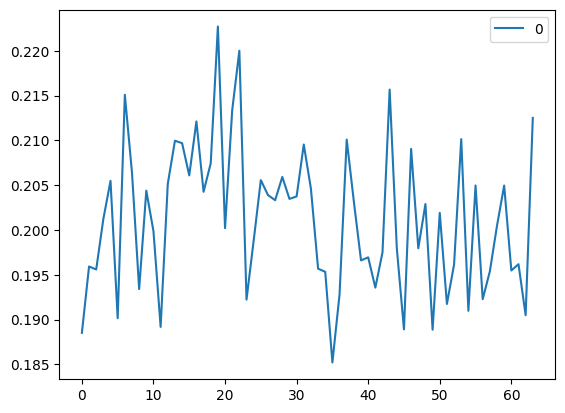

In [47]:
pd.DataFrame(fake_data.detach().numpy()).plot()

In [48]:
F.mse_loss(fake_noise, z1)

tensor(22.9427, grad_fn=<MseLossBackward0>)